In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
rng = np.random.default_rng()

In [59]:
df = pd.read_excel("Synthetic Data.xlsx")
df.head()

,player_id,name,age,base_torso_x,base_torso_y,upper_arm_length,forearm_length,thigh_length,shin_length,head_vertical_offset,shoulder_horizontal_offset,shoulder_vertical_offset,hip_horizontal_offset,hip_vertical_offset,agility,presence,flexibility,reflexes
0,0,Pedro Farelo,29,13,15,3.5,3.0,6.0,4.5,2.5,2.0,1.5,1.5,3.0,90,85,85,80
1,1,Vasco Palmeirim,23,13,15,3.3,3.1,6.0,4.3,2.4,1.8,1.4,1.5,2.9,80,90,80,75
2,2,José Saramago,38,11,15,3.6,3.0,6.1,4.5,2.5,2.0,1.7,1.5,3.0,70,90,90,60
3,3,Eça de Queirós,31,13,14,3.5,2.9,6.2,4.6,2.6,2.0,1.5,1.5,3.1,75,65,70,70


In [60]:
def get_player_info(player_id):
    player = df[df["player_id"] == player_id]
    if player.empty:
        print(f"Player ID {player_id} not found.")
        return None
    return player

In [61]:
def torso_coordinate_modifier(player, torso_coordinate, shot_coordinate, shot_velocity):
    reflexes = player["reflexes"]
    agility = player["agility"]
    distance = shot_coordinate - torso_coordinate

    torso_coordinate += distance * 0.2 * (reflexes * 1.54) / shot_velocity - (100 - agility) * 0.001
    return torso_coordinate

In [62]:
def generate_torso_position(player, shot_coordinates, shot_velocity):
    base_torso_coordinates = [player["base_torso_x"], player["base_torso_y"]]

    torso = {
        "x": torso_coordinate_modifier(player, base_torso_coordinates[0], shot_coordinates[0], shot_velocity),
        "y": torso_coordinate_modifier(player, base_torso_coordinates[1], shot_coordinates[1], shot_velocity)
    }
    '''
    torso = {
        "x": torso_coordinate_modifier(base_torso_coordinates[0], shot_coordinates[0]),
        "y": torso_coordinate_modifier(base_torso_coordinates[1], shot_coordinates[1])
    }
    '''
    return torso

In [63]:
def generate_head_position(player, torso):
    head_vertical_offset = player["head_vertical_offset"]
    head = {
        "x": torso["x"] + rng.normal(0, 0.2),
        "y": torso["y"] + head_vertical_offset + rng.uniform(-0.3,0.1)
    }
    return head

In [64]:
def place_arm_toward_target(player, shoulder_coordinates, target_coordinates, region="center"):
    max_reach = player["upper_arm_length"] + player["forearm_length"]
    flexibility = player["flexibility"]

    dx = target_coordinates[0] - shoulder_coordinates["x"]
    dy = target_coordinates[1] - shoulder_coordinates["y"]
    distance = np.sqrt(dx**2 + dy**2)

    if distance > max_reach:
        reach_factor = max_reach * 0.95 * (flexibility * 0.01)
    else:
        reach_factor = distance * rng.uniform(0.85, 0.98) * (flexibility * 0.01)
    
    hand = {
            "x": shoulder_coordinates["x"] + (dx / distance) * reach_factor,
            "y": shoulder_coordinates["y"] + (dy / distance) * reach_factor
        }
    
    elbow = calculate_elbow_position(
        shoulder_coordinates,
        hand,
        player["upper_arm_length"],
        player["forearm_length"],
        region
    )

    return elbow, hand

def calculate_elbow_position(shoulder, hand, upper_arm_length, forearm_length, region):
    dx = hand["x"] - shoulder["x"]
    dy = hand["y"] - shoulder["y"]
    distance = np.sqrt(dx**2 + dy**2)

    distance = min(distance, upper_arm_length + forearm_length - 0.1)

    cos_elbow = (upper_arm_length**2 + forearm_length**2 - distance**2) / (2 * upper_arm_length * forearm_length)
    cos_elbow = np.clip(cos_elbow, -1, 1)
    #elbow_angle = np.arccos(cos_elbow)

    baseline_angle = np.arctan2(dy, dx)

    cos_shoulder = (upper_arm_length**2 + distance**2 - forearm_length**2) / (2 * upper_arm_length * distance)
    cos_shoulder = np.clip(cos_shoulder, -1, 1)
    shoulder_angle = np.arccos(cos_shoulder)

    if region == "right":
        elbow_direction = baseline_angle - shoulder_angle
    else:
        elbow_direction = baseline_angle + shoulder_angle

    elbow = {
        "x": shoulder["x"] + upper_arm_length * np.cos(elbow_direction),
        "y": shoulder["y"] + upper_arm_length * np.sin(elbow_direction)
    }

    return elbow

In [65]:
def place_balance_arm(player, shoulder_coordinates, torso, region):
    target_coordinates = [0, 0]

    if region == "right":
        target_coordinates[0] = shoulder_coordinates["x"] + 3
    else:
        target_coordinates[0] = shoulder_coordinates["x"] - 3

    target_coordinates[1] = torso["y"] + rng.uniform(-1, 2)

    elbow, hand = place_arm_toward_target(player, shoulder_coordinates, target_coordinates, region)
    return elbow, hand      

In [66]:
def place_leg_toward_target(player, hip_coordinates, target_coordinates, region="right"):
    max_reach = player["thigh_length"] + player["shin_length"]
    flexibility = player["flexibility"]

    dx = target_coordinates[0] - hip_coordinates["x"]
    dy = target_coordinates[1] - hip_coordinates["y"]
    distance = np.sqrt(dx**2 + dy**2)

    if distance > max_reach:
        reach_factor = max_reach * 0.95 * (flexibility * 0.01)
    else:
        reach_factor = distance * rng.uniform(0.85, 0.98) * (flexibility * 0.01)
    
    foot = {
            "x": hip_coordinates["x"] + (dx / distance) * reach_factor,
            "y": hip_coordinates["y"] + (dy / distance) * reach_factor
        }
    
    knee = calculate_knee_position(
        hip_coordinates,
        foot,
        player["thigh_length"],
        player["shin_length"],
        region
    )

    return knee, foot

def calculate_knee_position(hip, foot, thigh_length, shin_length, region):
    dx = foot["x"] - hip["x"]
    dy = foot["y"] - hip["y"]
    distance = np.sqrt(dx**2 + dy**2)

    distance = np.clip(distance, abs(thigh_length - shin_length) + 1e-6,
                   thigh_length + shin_length - 1e-6)
    
    x = (thigh_length**2 - shin_length**2 + distance**2) / (2 * distance)

    h_sq = thigh_length**2 - x**2
    h = np.sqrt(max(h_sq, 0.0))

    ux = dx / distance
    uy = dy / distance

    px = -uy
    py = ux

    if region == "right":
        sign = 1
    else:
        sign = -1

    '''
    distance = min(distance, thigh_length + shin_length - 0.1)

    cos_knee = (thigh_length**2 + shin_length**2 - distance**2) / (2 * thigh_length * shin_length)
    cos_knee = np.clip(cos_knee, -1, 1)
    knee_angle = np.arccos(cos_knee)

    baseline_angle = np.arctan2(dy, dx)

    cos_hip = (thigh_length**2 + distance**2 - shin_length**2) / (2 * thigh_length * distance)
    cos_hip = np.clip(cos_hip, -1, 1)
    hip_angle = np.arccos(cos_hip)

    if region == "right":
        knee_direction = baseline_angle + hip_angle
    else:
        knee_direction = baseline_angle - hip_angle

    knee = {
        "x": hip["x"] + thigh_length * np.cos(knee_direction),
        "y": hip["y"] + thigh_length * np.sin(knee_direction)
    }
    '''

    knee = {
        "x": hip["x"] + x * ux + sign * h * px,
        "y": hip["y"] + x * uy + sign * h * py
    }

    return knee

In [67]:
def place_supporting_leg(player, hip_coordinates, region="center"):
    target_coordinates = [0, 0]

    if region == "center":
        target_coordinates[0] = hip_coordinates["x"] + rng.uniform(-1, 1)
    elif region == "right":
        target_coordinates[0] = hip_coordinates["x"] + 2
    else:
        target_coordinates[0] = hip_coordinates["x"] - 2

    target_coordinates[1] = rng.uniform(0, 3)

    knee, foot = place_leg_toward_target(player, hip_coordinates, target_coordinates, region)
    return knee, foot

In [68]:
def generate_pose(player_id, shot_coordinates, shot_velocity):
    player = get_player_info(player_id).iloc[0]
    torso = generate_torso_position(player, shot_coordinates, shot_velocity)
    head = generate_head_position(player, torso)

    shoulder_horizontal_offset = player["shoulder_horizontal_offset"]
    shoulder_vertical_offset = player["shoulder_vertical_offset"]
    left_shoulder = {"x": torso["x"] - shoulder_horizontal_offset, "y": torso["y"] + shoulder_vertical_offset}
    right_shoulder = {"x": torso["x"] + shoulder_horizontal_offset, "y": torso["y"] + shoulder_vertical_offset}

    hip_horizontal_offset = player["hip_horizontal_offset"]
    hip_vertical_offset = player["hip_vertical_offset"]
    left_hip = {"x": torso["x"] - hip_horizontal_offset, "y": torso["y"] - hip_vertical_offset}
    right_hip = {"x": torso["x"] + hip_horizontal_offset, "y": torso["y"] - hip_vertical_offset}

    dx = shot_coordinates[0] - torso["x"]

    if shoulder_horizontal_offset > abs(dx):
        left_elbow, left_hand = place_arm_toward_target(player, left_shoulder, shot_coordinates, region="center")
        right_elbow, right_hand = place_arm_toward_target(player, right_shoulder, shot_coordinates, region="center")
        left_knee, left_foot = place_supporting_leg(player, left_hip, region="center")
        right_knee, right_foot = place_supporting_leg(player, right_hip, region="center")
    elif shot_coordinates[0] < torso["x"]:
        left_elbow, left_hand = place_arm_toward_target(player, left_shoulder, shot_coordinates, region="left")
        right_elbow, right_hand = place_balance_arm(player, right_shoulder, torso, region="right")
        if shot_coordinates[1] > torso["y"]*1.1:
            left_knee, left_foot = place_supporting_leg(player, left_hip, region="center")
            right_knee, right_foot = place_supporting_leg(player, right_hip, region="center")
        else:
            left_knee, left_foot = place_leg_toward_target(player, left_hip, shot_coordinates, region="left")
            right_knee, right_foot = place_supporting_leg(player, right_hip, region="right")
    else:
        right_elbow, right_hand = place_arm_toward_target(player, right_shoulder, shot_coordinates, region="right")
        left_elbow, left_hand = place_balance_arm(player, left_shoulder, torso, region="left")
        if shot_coordinates[1] > torso["y"]*1.1:
            right_knee, right_foot = place_supporting_leg(player, right_hip, region="center")
            left_knee, left_foot = place_supporting_leg(player, left_hip, region="center")
        else:
            right_knee, right_foot = place_leg_toward_target(player, right_hip, shot_coordinates, region="right")
            left_knee, left_foot = place_supporting_leg(player, left_hip, region="left")

    return {
        "torso": torso,
        "head": head,
        "left_shoulder": left_shoulder,
        "left_elbow": left_elbow,
        "left_hand": left_hand,
        "left_hip": left_hip,
        "left_knee": left_knee,
        "left_foot": left_foot,
        "right_shoulder": right_shoulder,
        "right_elbow": right_elbow,
        "right_hand": right_hand,
        "right_hip": right_hip,
        "right_knee": right_knee,
        "right_foot": right_foot
    }

In [79]:
def pose_to_dataframe(pose):
    df = pd.DataFrame(pose).T
    df.columns = ["x", "y"]
    df.index.name = "node"
    return df

In [81]:
pose = generate_pose(0, [24, 23], 100)
pose = pose_to_dataframe(pose)
pose

,x,y
node,,
torso,15.700400,16.961200
head,15.514958,19.479755
left_shoulder,13.700400,18.461200
left_elbow,12.194538,15.301710
left_hand,11.261118,18.152802
left_hip,14.200400,13.961200
left_knee,11.064336,8.846016
left_foot,14.055121,5.483695
right_shoulder,17.700400,18.461200


In [83]:
def find_nearest_node(pose, shot_coordinates):
    if isinstance(pose, dict):
        df = pose_to_dataframe(pose)
    else:
        df = pose

    sx, sy = shot_coordinates
    dx = df["x"] - sx
    dy = df["y"] - sy
    d2 = dx * dx + dy * dy
    nearest = d2.idxmin()
    distance = float(np.sqrt(d2.loc[nearest]))
    return nearest, distance

In [ ]:
def evaluate_save(pose_df, shot_coordinates, radius=1.0):
    node, distance = find_nearest_node(pose_df, shot_coordinates)
    return {
        "nearest_node": node,
        "distance": distance,
        "radius": float(radius),
        "saved": bool(distance <= radius),
    }

In [111]:
shot = [21, 19]
pose = generate_pose(0, shot, 100)
eval_result = evaluate_save(pose_df, shot, radius=1.0)
eval_result

{'nearest_node': 'right_elbow',
 'distance': 0.4207008346403866,
 'radius': 1.0,
 'saved': True}

NameError: name 'nearest' is not defined

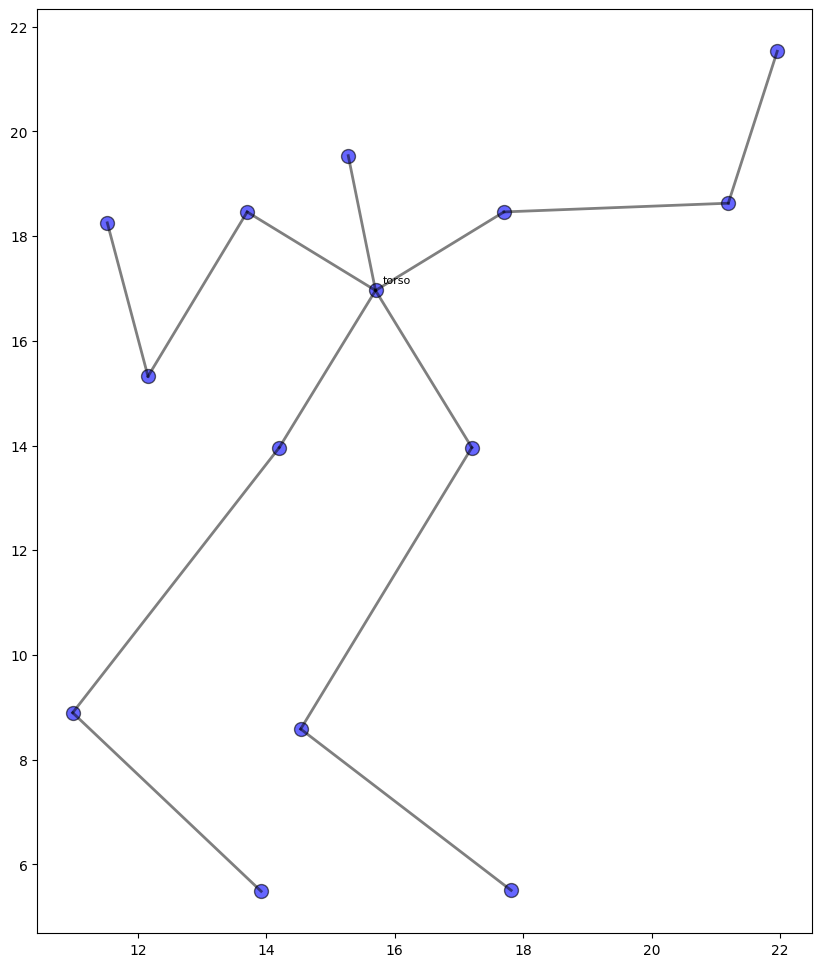

In [117]:
plt.figure(figsize=(10, 12))
plt.scatter(pose_df['x'], pose_df['y'], s=100, c='blue', alpha=0.6, edgecolors='black')

for node, (x, y) in pose_df.iterrows():
    plt.annotate(node, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

    # Draw skeleton connections (same as in physicsbasedposes.py)
    connections = [
        ('torso', 'head'),
        ('torso', 'left_shoulder'), ('torso', 'right_shoulder'),
        ('left_shoulder', 'left_elbow'), ('left_elbow', 'left_hand'),
        ('right_shoulder', 'right_elbow'), ('right_elbow', 'right_hand'),
        ('torso', 'left_hip'), ('torso', 'right_hip'),
        ('left_hip', 'left_knee'), ('left_knee', 'left_foot'),
        ('right_hip', 'right_knee'), ('right_knee', 'right_foot')
    ]

    for node1, node2 in connections:
        x_vals = [pose_df.loc[node1, 'x'], pose_df.loc[node2, 'x']]
        y_vals = [pose_df.loc[node1, 'y'], pose_df.loc[node2, 'y']]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.5, linewidth=2)

    # Highlight nearest node and draw radius circle
    nx, ny = pose_df.loc[nearest, 'x'], pose_df.loc[nearest, 'y']
    plt.scatter(nx, ny, s=140, color='orange', zorder=4, label='Nearest node')
    circle = Circle((nx, ny), radius, color='green' if saved else 'red', fill=False, linestyle='--', linewidth=2, alpha=0.7)
    plt.add_patch(circle)

    # Plot shot location
    plt.scatter(shot_x, shot_y, s=200, marker='*', color='red', label='Shot', zorder=5)

    plt.set_xlabel('X Position')
    plt.set_ylabel('Y Position')
    plt.set_title('Goalkeeper Pose Visualization')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.set_xlim(0, 27)
    plt.set_ylim(0, 27)
plt.show()